# Introduction
## Contexte de l'étude
Cette analyse s'appuie sur les données de l'article scientifique intitulé "Framing side effects positively improves clinical trial participants’ perceived control and reduces symptom burden: A randomized controlled trial", publié dans PLOS ONE (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0209851#pone-0209851-g001).
L'étude explore comment le cadrage positif des effets secondaires (en les présentant comme un signe que le médicament est actif) influence la perception des participants et leur fardeau symptomatique, par rapport à un cadrage neutre ou négatif.

### Source des données
Les données utilisées dans ce notebook proviennent du fichier Excel raw_data_framing_side_effects_positively.xlsx, qui contient les données brutes de l'étude. Ce fichier est structuré en deux feuilles :

raw_data : Contient les données des participants, y compris les scores de douleur, les effets secondaires, les scores psychologiques, etc.

metadata : Fournit une description des colonnes et des variables.

## Objectif du notebook
Ce notebook Jupyter a pour objectif de :

1) Décrire et explorer les données (DATA_description) pour comprendre leur structure et leur contenu.

2) Valider les calculs statistiques effectués dans l'article en reproduisant les analyses.

3) Identifier les modèles statistiques utilisés dans l'article et les hypothèses testées.

 4) Effectuer un rééchantillonnage pour vérifier la robustesse des résultats.



## 1. DATA_description


Objectif

Explorer les données pour comprendre leur structure, les variables disponibles et les relations entre elles.

Identifier les variables clés (par exemple, scores de douleur, effets secondaires, scores psychologiques)

#### 1.1.Importation des données : Charger le fichier Excel et explorer les premières lignes.

In [2]:
import pandas as pd


file_path = r"C:\Users\nassi\OneDrive\Desktop\nassim dammak\annee universitaire 2024-2025\INRIA\statistiques-\raw_data_framing_side_effects_positively.xlsx"
df = pd.read_excel(file_path, sheet_name="raw_data")

 
df.head()

,record_id,@1N_2P,mean_mod_Av,mean_mod_Après,Delta_Mean_Mod,LOT_Score,score_ASI,Score_stai,Score_Pers,Score_Cat,...,age,conc1,anx1,fatigue1,conc2,anx2,fatigue2,seq_test,mean_intensity_total,mean_intensity_attr
0,102,1,2.828571,1.957143,-0.871429,17,22,20,28,-,...,18,8.0,1.0,6.0,8.0,0,6.0,46.0,1.600000,1.0
1,104,1,3.685714,2.842857,-0.842857,18,20,26,44,-,...,22,6.0,0.0,7.0,7.0,0,5.0,46.0,1.666667,1.0
2,105,1,3.557143,1.700000,-1.857143,18,8,26,37,0,...,21,7.0,2.0,4.0,8.0,5,4.0,47.0,1.000000,1.0
3,106,1,3.842857,3.857143,0.014286,14,20,36,42,1,...,22,8.0,3.0,4.0,0.0,0,0.0,47.0,1.000000,1.0
4,107,1,4.100000,4.657143,0.557143,17,6,20,24,0,...,30,5.0,0.0,2.0,5.0,0,2.0,47.5,0.000000,0.0


#### 1.2.	Nettoyage des données : Vérifier les valeurs manquantes, les formats de données et les éventuelles erreurs.

In [3]:
# Vérifier les valeurs manquantes
missing_values = df.isnull().sum()
print("Valeurs manquantes par colonne :")
print(missing_values)

# Afficher le nombre total de valeurs manquantes
total_missing_values = missing_values.sum()
print("\nNombre total de valeurs manquantes :", total_missing_values)

# Afficher les lignes contenant des valeurs manquantes
rows_with_missing_values = df[df.isnull().any(axis=1)]
print("\nLignes contenant des valeurs manquantes :")
print(rows_with_missing_values if not rows_with_missing_values.empty else "Aucune ligne avec des valeurs manquantes.")

# Afficher les types des colonnes clairement
print("\nTypes des colonnes :")
for col in df.columns:
    print(f"{col}: {df[col].dtype}")

# Vérifier les valeurs invalides dans la colonne 'age'
if 'age' in df.columns:
    invalid_age = df[df['age'] < 0]
    print("\nValeurs invalides dans la colonne 'age' :")
    print(invalid_age if not invalid_age.empty else "Aucune valeur invalide trouvée.")

    # Afficher le nombre total de valeurs invalides dans la colonne 'age'
    total_invalid_age = invalid_age.shape[0]
    print("\nNombre total de valeurs invalides dans la colonne 'age' :", total_invalid_age)

    # Corriger les erreurs en remplaçant les valeurs négatives par NaN
    df.loc[df['age'] < 0, 'age'] = pd.NA


    # Remplacer les groupes 1 → Contrôle, 2 → Positif
df['Groupe'] = df['@1N_2P'].replace({1: 'Contrôle', 2: 'Positif'})

Valeurs manquantes par colonne :
record_id               0
@1N_2P                  0
mean_mod_Av             0
mean_mod_Après          0
Delta_Mean_Mod          0
                       ..
anx2                    0
fatigue2                0
seq_test                0
mean_intensity_total    0
mean_intensity_attr     0
Length: 70, dtype: int64

Nombre total de valeurs manquantes : 63

Lignes contenant des valeurs manquantes :
    record_id  @1N_2P  mean_mod_Av  mean_mod_Après  Delta_Mean_Mod  LOT_Score  \
1         104       1     3.685714        2.842857       -0.842857         18   
2         105       1     3.557143        1.700000       -1.857143         18   
3         106       1     3.842857        3.857143        0.014286         14   
4         107       1     4.100000        4.657143        0.557143         17   
5         111       1     7.414286        6.600000       -0.814286         16   
..        ...     ...          ...             ...             ...        ...   
61   

#### 1.3	Statistiques descriptives : Calculer des indicateurs clés (moyennes, écarts-types, etc.) pour chaque groupe (contrôle vs positif).

Sépare les données en deux groupes (groupe_controle et groupe_positif) en utilisant la colonne @1N_2P.
Calcule la moyenne, l'écart-type, la médiane et le nombre d'observations pour chaque groupe.
Crée un DataFrame statistiques_df pour afficher les résultats sous forme de tableau.
Affiche les résultats

In [4]:
# statistiques descriptives
statistiques_df = df.groupby('@1N_2P')['Delta_Mean_Mod'].describe()

# resultat
display(statistiques_df)


,count,mean,std,min,25%,50%,75%,max
@1N_2P,,,,,,,,
1,33.0,-1.026840,1.173059,-2.957143,-2.014286,-0.828571,-0.057143,1.042857
2,33.0,-1.052381,1.221364,-4.171429,-1.742857,-1.100000,-0.100000,1.000000


#### 1.4	Visualisations : Créer des graphiques pour explorer les distributions et les relations entre les variables.

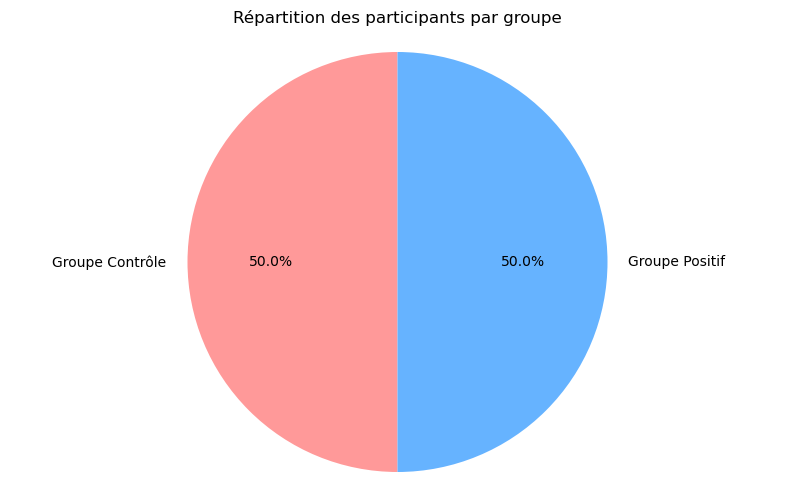

<Figure size 1000x600 with 0 Axes>

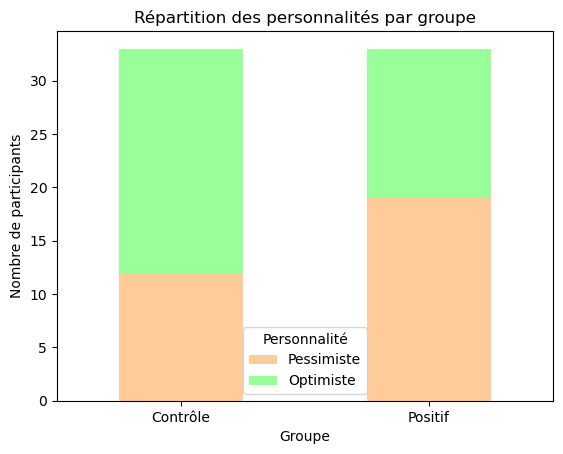

<Figure size 1000x600 with 0 Axes>

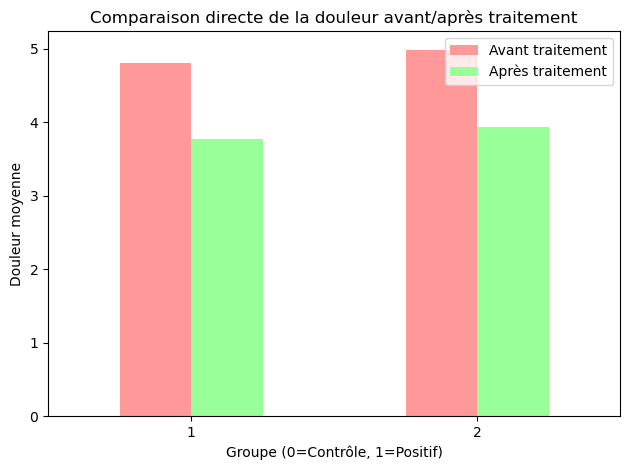

<Figure size 1000x600 with 0 Axes>

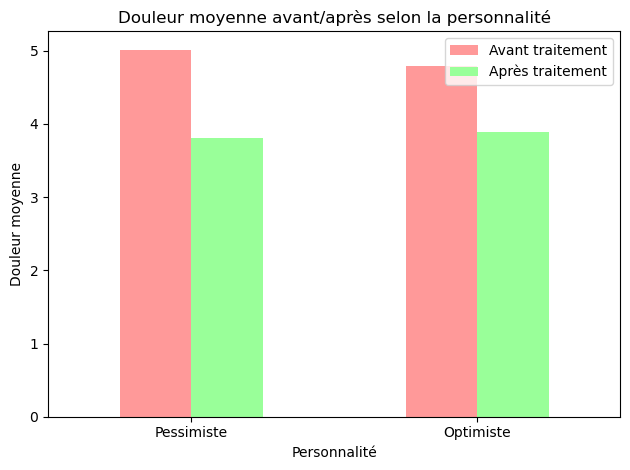

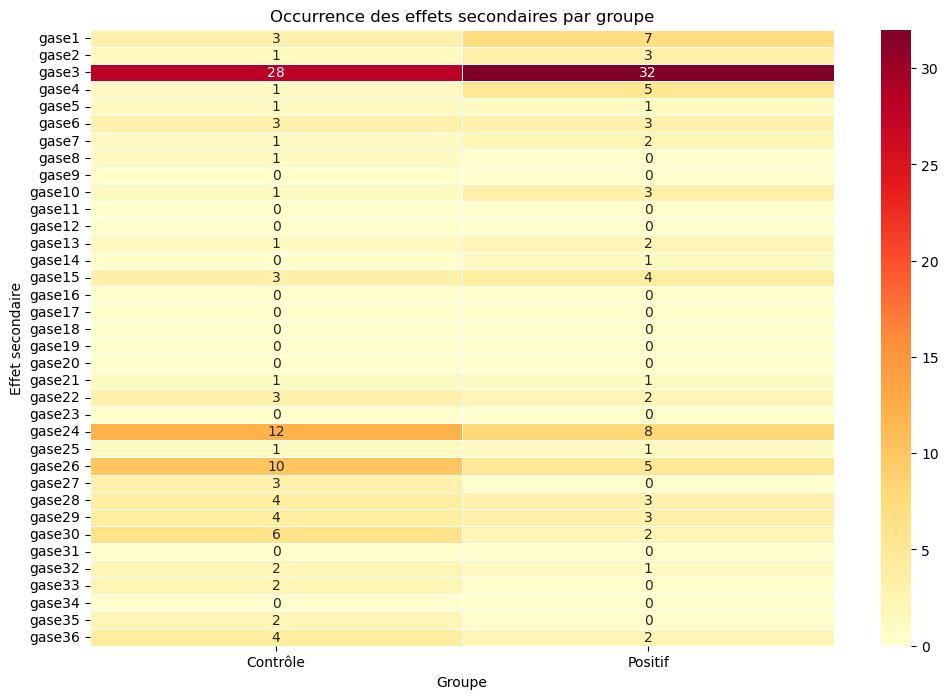


Top 5 des effets secondaires les plus fréquents :
Bouche sèche: 60
Fatigue, perte d’énergie: 20
Insomnie, troubles du sommeil: 15
Mal de tête: 10
Douleur articulaire: 8


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
#1. Compter le nombre de personnes dans chaque groupe

counts = df['@1N_2P'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(counts, 
        labels=['Groupe Contrôle', 'Groupe Positif'], 
        colors=['#ff9999','#66b3ff'],
        autopct='%1.1f%%',
        startangle=90)
plt.title('Répartition des participants par groupe')
plt.axis('equal')  # Pour un cercle parfait
plt.show()


#2. Compter les personnalités dans chaque groupe

median_lot = df["LOT_Score"].median()

personality_counts = df.groupby(['@1N_2P', df["LOT_Score"] >= median_lot]).size().unstack()
personality_counts.columns = ["Pessimiste", "Optimiste"]

plt.figure(figsize=(10, 6))
personality_counts.plot(kind='bar', stacked=True, color=['#ffcc99','#99ff99'])
plt.title('Répartition des personnalités par groupe')
plt.xlabel('Groupe')
plt.ylabel('Nombre de participants')
plt.xticks([0, 1], ['Contrôle', 'Positif'], rotation=0)
plt.legend(title='Personnalité')
plt.show()

#3. Version ultra-simple pour la douleur

plt.figure(figsize=(10, 6))
resultats = df.groupby('@1N_2P')[['mean_mod_Av', 'mean_mod_Après']].mean()
resultats.plot(kind='bar', color=['#FF9999', '#99FF99'])
plt.title('Comparaison directe de la douleur avant/après traitement')
plt.xlabel('Groupe (0=Contrôle, 1=Positif)')
plt.ylabel('Douleur moyenne')
plt.xticks(rotation=0)
plt.legend(['Avant traitement', 'Après traitement'])
plt.tight_layout()
plt.show()

#4. Version ultra-simple pour la douleur (par personnalité)
plt.figure(figsize=(10, 6))
resultats_perso = df.groupby([df["LOT_Score"] >= median_lot])[['mean_mod_Av', 'mean_mod_Après']].mean()
resultats_perso.index = ["Pessimiste", "Optimiste"]
resultats_perso.plot(kind='bar', color=['#FF9999', '#99FF99'])
plt.title('Douleur moyenne avant/après selon la personnalité')
plt.xlabel('Personnalité')
plt.ylabel('Douleur moyenne')
plt.xticks(rotation=0)
plt.legend(['Avant traitement', 'Après traitement'])
plt.tight_layout()
plt.show()

#5. Carte thermique des effets secondaires par groupe
effets_par_groupe = df.groupby('@1N_2P')[[col for col in df.columns if col.startswith('gase')]].sum().T
effets_par_groupe.columns = ['Contrôle', 'Positif']

plt.figure(figsize=(12, 8))
sns.heatmap(effets_par_groupe, annot=True, fmt='d', cmap='YlOrRd', linewidths=0.5)
plt.title('Occurrence des effets secondaires par groupe')
plt.xlabel('Groupe')
plt.ylabel('Effet secondaire')
plt.show()

# 6. Top 5 des effets secondaires les plus fréquents avec descriptions
top_5_effets = effets_par_groupe.sum(axis=1).nlargest(5)

# Création d'un dictionnaire de correspondance entre codes GASE et descriptions
gase_descriptions = {
    'gase1': 'Mal de tête',
    'gase2': 'Perte de cheveux',
    'gase3': 'Bouche sèche',
    'gase4': 'Vertiges',
    'gase5': 'Douleur thoracique',
    'gase6': 'Palpitations, rythme cardiaque irrégulier',
    'gase7': 'Problèmes respiratoires',
    'gase8': 'Hypotension, autres problèmes de circulation',
    'gase9': 'Douleurs abdominales',
    'gase10': 'Nausées',
    'gase11': 'Vomissements',
    'gase12': 'Constipation',
    'gase13': 'Diarrhée',
    'gase14': 'Diminution de l’appétit',
    'gase15': 'Augmentation de l’appétit',
    'gase16': 'Difficultés à uriner',
    'gase17': 'Problèmes de performance sexuelle ou des organes sexuels',
    'gase18': 'Éruption cutanée ou démangeaisons',
    'gase19': 'Tendance aux ecchymoses (bleus)',
    'gase20': 'Fièvre, température corporelle élevée',
    'gase21': 'Transpiration anormale',
    'gase22': 'Bouffées de chaleur',
    'gase23': 'Convulsions ou crises d’épilepsie',
    'gase24': 'Fatigue, perte d’énergie',
    'gase25': 'Tremblements',
    'gase26': 'Insomnie, troubles du sommeil',
    'gase27': 'Cauchemars ou rêves anormaux',
    'gase28': 'Douleur au dos',
    'gase29': 'Douleur musculaire',
    'gase30': 'Douleur articulaire',
    'gase31': 'Agitation',
    'gase32': 'Irritabilité, nervosité',
    'gase33': 'Humeur dépressive',
    'gase34': 'Pensées suicidaires',
    'gase35': 'Anxiété, peur',
    'gase36': 'Divers'
}
print("\nTop 5 des effets secondaires les plus fréquents :")
for gase_code, count in top_5_effets.items():
    print(f"{gase_descriptions.get(gase_code, gase_code)}: {count}")

 ## 2. Valider les calculs statistiques effectués dans l'article en reproduisant les analyses.
 
Objectif : Reproduire les analyses statistiques de l'article
L'article examine l'effet du cadrage sur la perception de la douleur et les effets secondaires en fonction de la personnalité. Il utilise :



#### 📖 2.1 Modèles utilisés (source : article PLOS ONE)


Les auteurs utilisent :
- ANOVA pour analyser les effets principaux du groupe et de la personnalité (optimisme)
- Régressions linéaires avec interactions :
    douleur_apres ~ Groupe + Optimisme + Groupe*Optimisme
- Tests t pour comparaisons simples
- Corrélation de Pearson pour relation entre deux variables continues

Source : section "Statistical analyses" de l'article
[section "Statistical analyses" de l’article](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0209851#sec011)


In [6]:
from scipy.stats import ttest_ind
import pandas as pd
import numpy as np
import statsmodels.stats.multitest as smm

# 📌 Liste des variables continues à comparer
variables = [
    'age', 'LOT_Score', 'Score_stai', 'score_ASI',
    'Score_Cat', 'exp_soulage_pers_n', 'mean_mod_Av',
    'mean_mod_Après', 'Delta_Mean_Mod'
]

results = []

for var in variables:
    # Conversion en numérique si besoin
    df[var] = pd.to_numeric(df[var], errors='coerce')

    # Création des sous-groupes
    g0 = df[df['Groupe'] == 'Contrôle'][var].dropna()
    g1 = df[df['Groupe'] == 'Positif'][var].dropna()

    # Vérification de la taille des groupes
    if len(g0) > 0 and len(g1) > 0:
        t, p = ttest_ind(g0, g1, equal_var=False)
    else:
        t, p = np.nan, np.nan

    results.append({
        'Variable': var,
        'Moyenne Contrôle': g0.mean(),
        'Écart-type Contrôle': g0.std(),
        'Moyenne Positif': g1.mean(),
        'Écart-type Positif': g1.std(),
        'Différence': g1.mean() - g0.mean(),
        't-stat': t,
        'p-value': p
    })

# Résumé des résultats
df_results = pd.DataFrame(results)

# Correction des p-values (non affichée mais utile)
_, p_corr, _, _ = smm.multipletests(df_results['p-value'], method='fdr_bh')
df_results['p-value corrigée'] = p_corr

# Tri par significativité
df_results.sort_values('p-value corrigée', inplace=True)
df_results.reset_index(drop=True, inplace=True)

# Arrondis
df_arrondi = df_results.round(1)
df_arrondi['p-value'] = df_results['p-value'].round(2)

# Colonnes à afficher
colonnes_afficher = [
    'Variable',
    'Moyenne Contrôle',
    'Écart-type Contrôle',
    'Moyenne Positif',
    'Écart-type Positif',
    'Différence',
    'p-value'
]

# Affichage final
pd.set_option('display.max_rows', None)
display(df_arrondi[colonnes_afficher])


,Variable,Moyenne Contrôle,Écart-type Contrôle,Moyenne Positif,Écart-type Positif,Différence,p-value
0,LOT_Score,16.6,4.8,15.1,4.2,-1.5,0.18
1,Score_stai,28.3,8.8,30.9,8.6,2.6,0.22
2,score_ASI,15.3,7.5,18.2,8.0,2.8,0.14
3,Score_Cat,1.6,1.7,2.3,2.3,0.7,0.20
4,exp_soulage_pers_n,5.9,1.9,6.6,4.1,0.6,0.42
5,mean_mod_Av,4.8,1.2,5.0,0.8,0.2,0.47
6,mean_mod_Après,3.8,1.6,3.9,1.4,0.2,0.66
7,age,24.2,4.0,24.5,4.3,0.3,0.77
8,Delta_Mean_Mod,-1.0,1.2,-1.1,1.2,-0.0,0.93


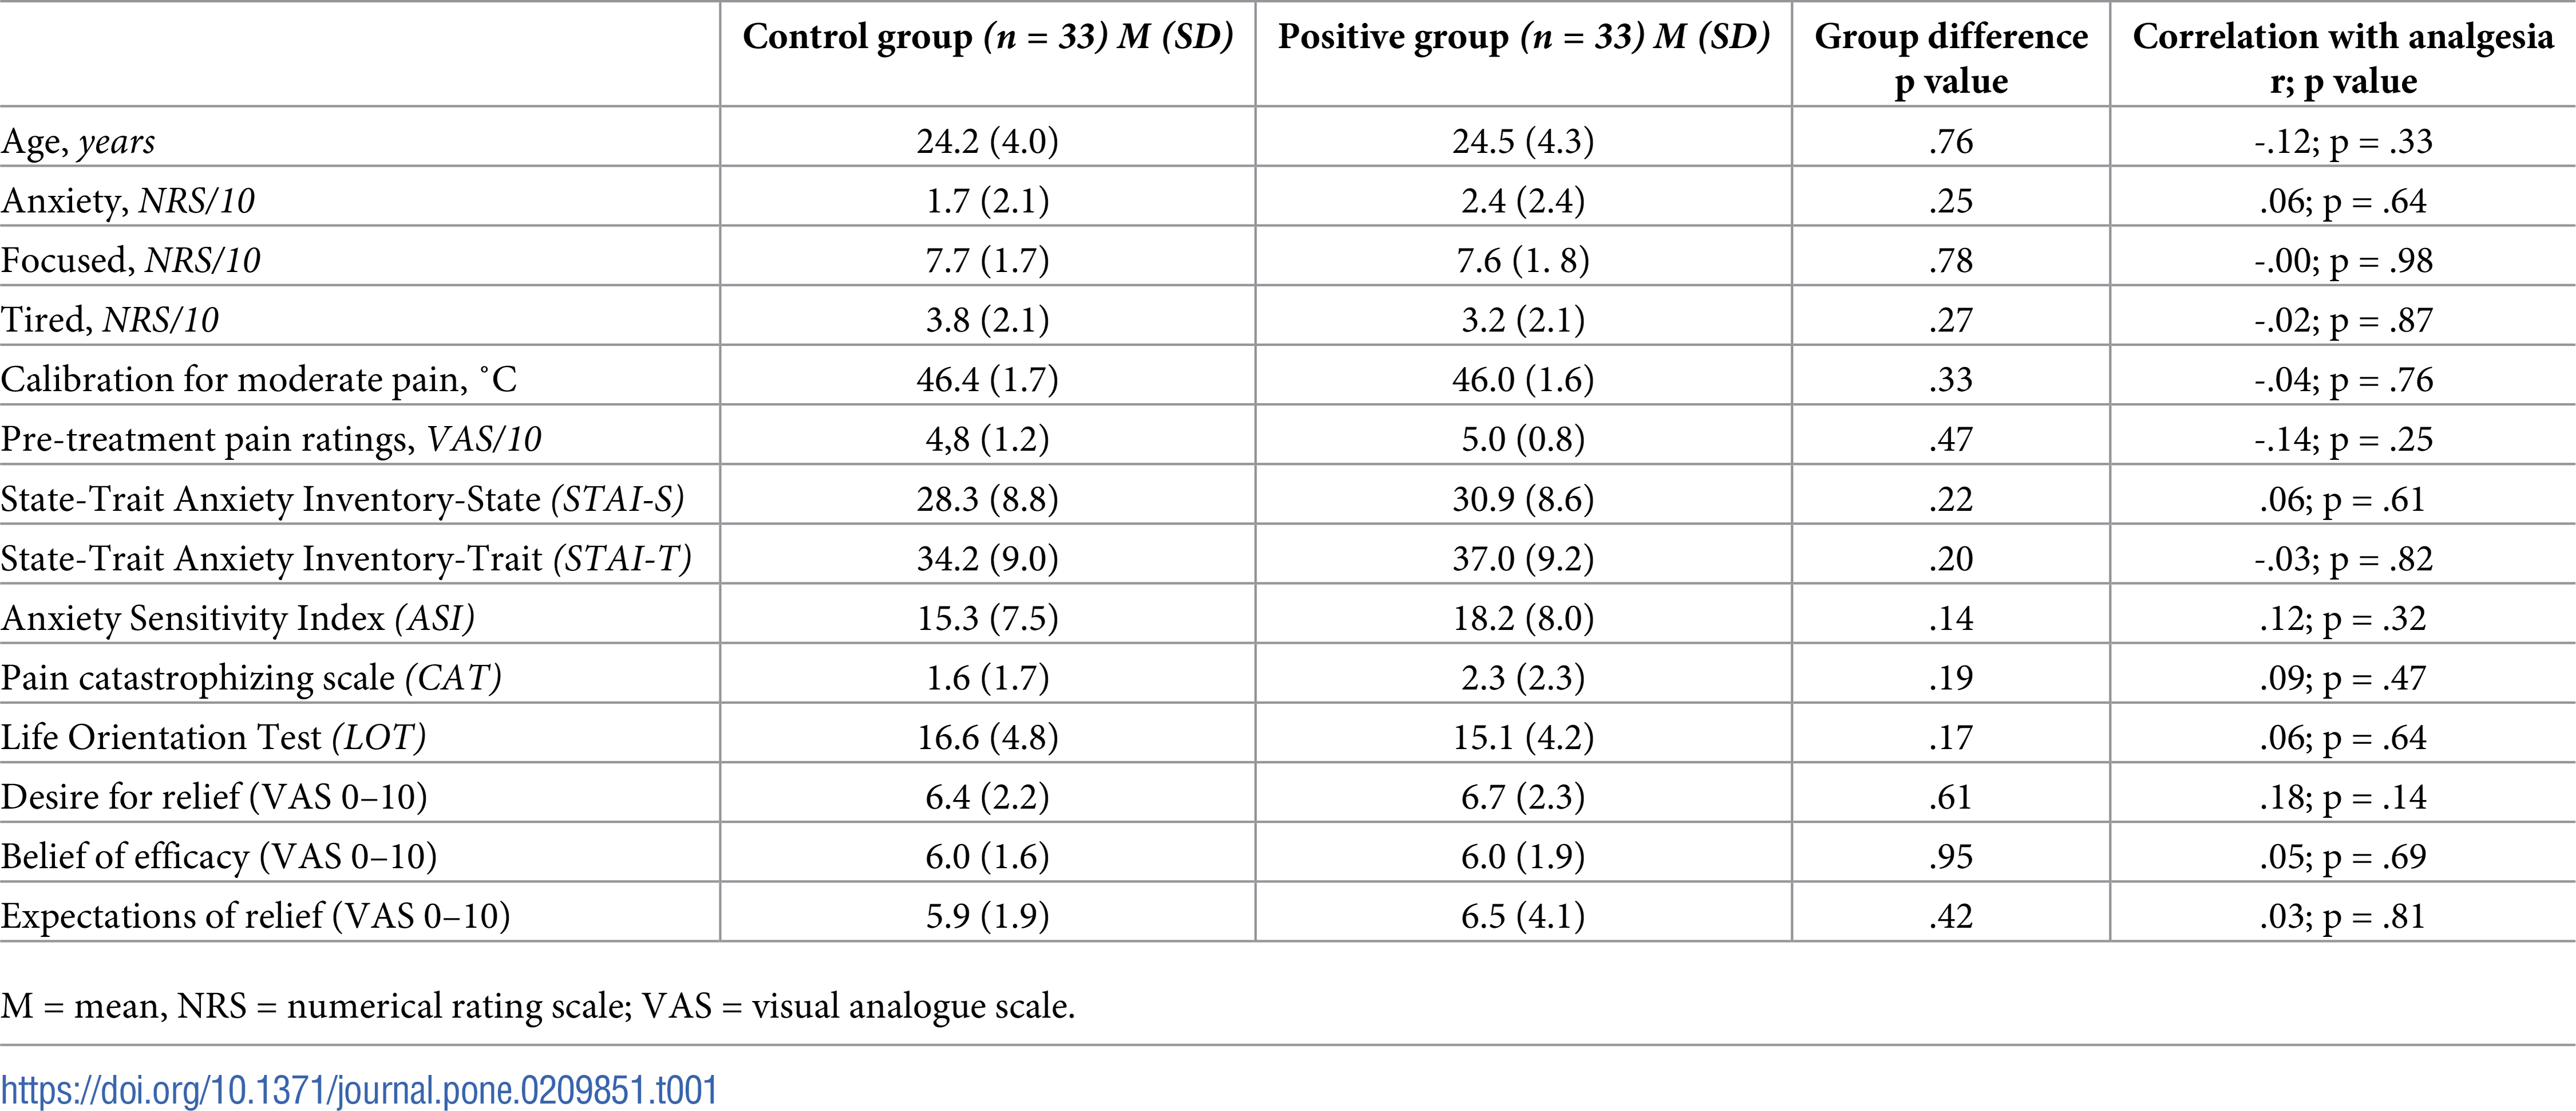

Globalement, mes données reproduisent fidèlement celles de l'article, confirmant l'absence de différences significatives entre les groupes contrôle et positif pour les variables mesurées avant le traitement. Cela renforce la validité de mon échantillon et de mon traitement des données.

#### 🤔 2.2 Hypothèses testées (source : introduction de l'article)




| Hypothèse | Formulation | Source exacte dans l'article |
|:---|:---|:---|
| H1 | Le cadrage positif réduit la douleur perçue et augmente les bénéfices perçus. | "We hypothesized that positive framing would increase participants' willingness to take the medication by reducing their perception of side effects and increasing the perceived benefits of the medication." (Introduction) |
| H2 | Le cadrage positif réduit les effets secondaires perçus. | "We hypothesized that positive framing would increase participants' willingness to take the medication by reducing their perception of side effects..." (Introduction) |
| H3 | L'effet du cadrage est modéré par le niveau d'optimisme. | "We also hypothesized that the effect of positive framing would be stronger among participants higher in dispositional optimism." (Introduction) |

> **Note** : Les tests de ces hypothèses sont détaillés dans la section *Statistical Analyses* de l'article.




🔍 H1 : Total GASE score
p-value : 0.7380

🔍 H2 : Douleur après traitement
p-value : 0.6623

🔍 H3 : Interaction Groupe x Optimiste (modèle de régression)
p-value : 0.8883


c:\Users\nassi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


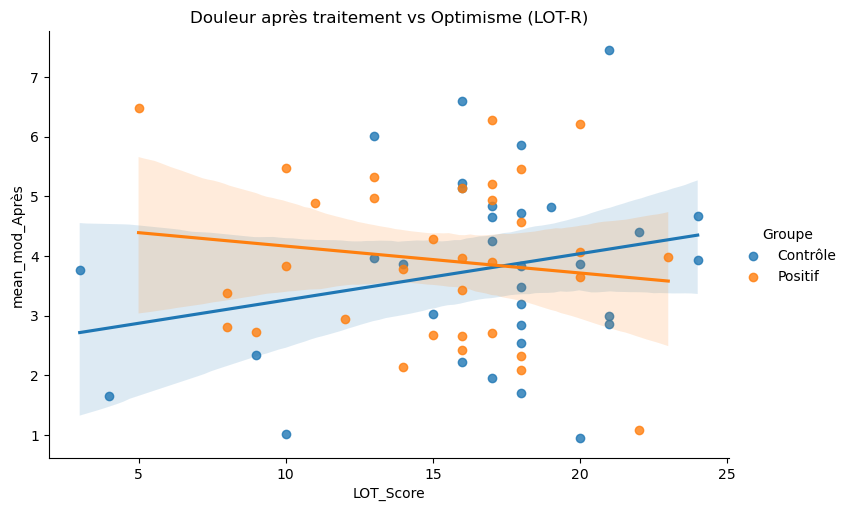

In [7]:
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

# 🔍 H1 — Le cadrage réduit les effets secondaires perçus (Total GASE)
print("\n🔍 H1 : Total GASE score")
if 'Total_GASE_score' in df.columns:
    controle = df[df['Groupe'] == 'Contrôle']
    positif = df[df['Groupe'] == 'Positif']
    stat_h1, pval_h1 = ttest_ind(controle['Total_GASE_score'], positif['Total_GASE_score'])
    print(f"p-value : {pval_h1:.4f}")


# 🔍 H2 — Le cadrage réduit la douleur perçue après traitement
print("\n🔍 H2 : Douleur après traitement")
stat_h2, pval_h2 = ttest_ind(controle['mean_mod_Après'], positif['mean_mod_Après'])
print(f"p-value : {pval_h2:.4f}")

# ✅ Création des colonnes nécessaires pour la régression (H3)
df['Groupe_num'] = df['Groupe'].map({'Contrôle': 0, 'Positif': 1})
df['Optimiste'] = (df['LOT_Score'] >= df['LOT_Score'].median()).astype(int)

# 🔍 H3 — L'effet du cadrage dépend de la personnalité (optimisme)
print("\n🔍 H3 : Interaction Groupe x Optimiste (modèle de régression)")
modele = smf.ols('mean_mod_Après ~ Groupe_num + Optimiste + Groupe_num:Optimiste', data=df).fit()
pval_h3 = modele.pvalues.get('Groupe_num:Optimiste', None)
print(f"p-value : {pval_h3:.4f}" if pval_h3 is not None else "Interaction non trouvée dans le modèle")

# 🔍 H4 — Vérification graphique (facultatif)
sns.lmplot(data=df, x='LOT_Score', y='mean_mod_Après', hue='Groupe', aspect=1.5)
plt.title("Douleur après traitement vs Optimisme (LOT-R)")
plt.show()


Les p-values obtenues (> 0.05) indiquent que les différences observées entre les groupes ne sont pas statistiquement significatives. Ainsi, aucun effet du cadrage ou de l’interaction avec l’optimisme n’a été détecté sur les variables mesurées dans cet échantillon. Cela ne signifie pas que l’effet n’existe pas, mais plutôt que les données actuelles ne permettent pas de le démontrer de manière fiable.


Le graphique montre une tendance visuelle opposée entre les groupes, mais les larges intervalles de confiance indiquent une forte incertitude. Cela est cohérent avec le test statistique (p = 0.8883) qui rejette l'hypothèse d'une interaction significative entre le cadrage de l'information et le niveau d'optimisme.


#### 2.3 Analyse de la corrélation entre analgésie et effets secondaires perçus

Dans cette section, nous analysons la relation entre la **réduction de douleur (analgésie)** et les **effets secondaires perçus** (*GASE*).

L'**analgésie** est définie comme :
> **Analgésie = Douleur après - Douleur avant**

Plus la valeur est **négative**, plus la diminution de douleur est importante.

---

Afin d'explorer cette relation, nous avons généré six graphiques distincts :

- **A** : Corrélation entre analgésie et score total GASE (tous participants)
- **A.1** : Corrélation pour le groupe contrôle uniquement
- **A.2** : Corrélation pour le groupe positif uniquement
- **B** : Corrélation entre analgésie et score GASE attribué au médicament (tous participants)
- **B.1** : Corrélation pour le groupe contrôle uniquement
- **B.2** : Corrélation pour le groupe positif uniquement

Pour chaque graphique, nous procédons selon la démarche suivante :
1. **Affichage** du graphique (nuage de points + droite de régression)
2. **Calcul** de la corrélation de Pearson (r) et de la p-value
3. **Interprétation** des résultats obtenus
4. **Comparaison** avec les résultats rapportés dans l'article de référence


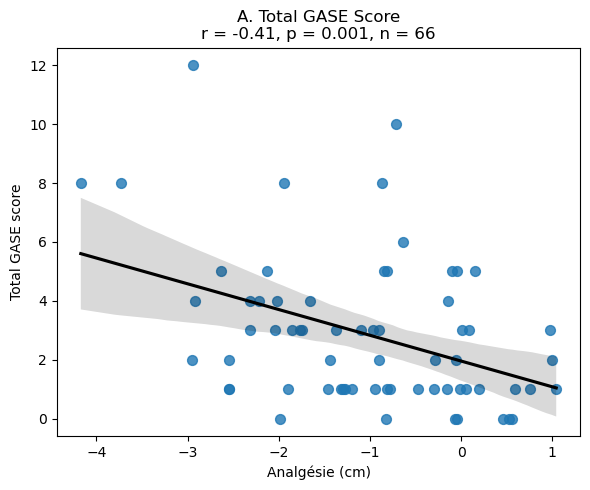

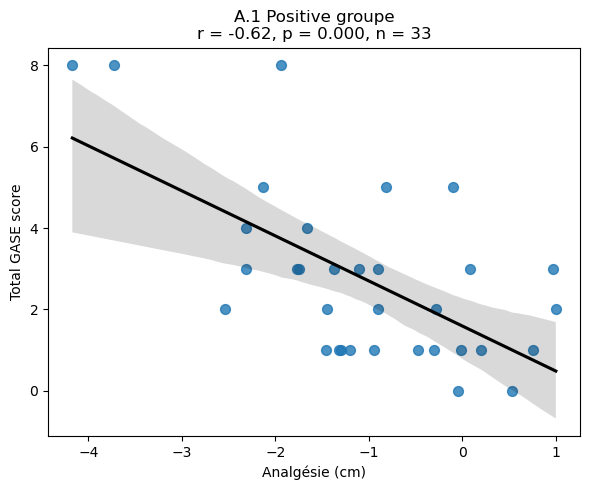

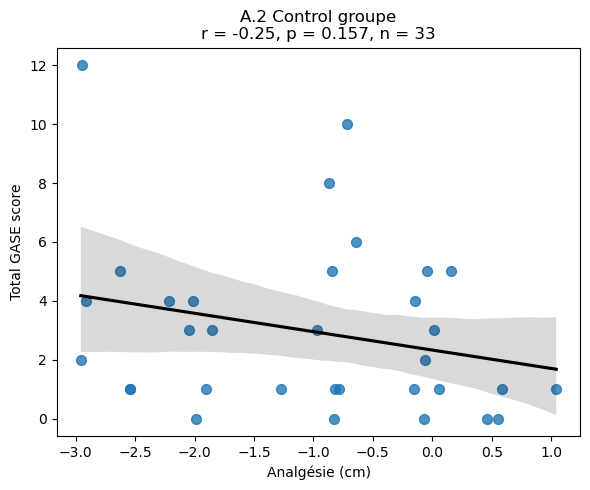

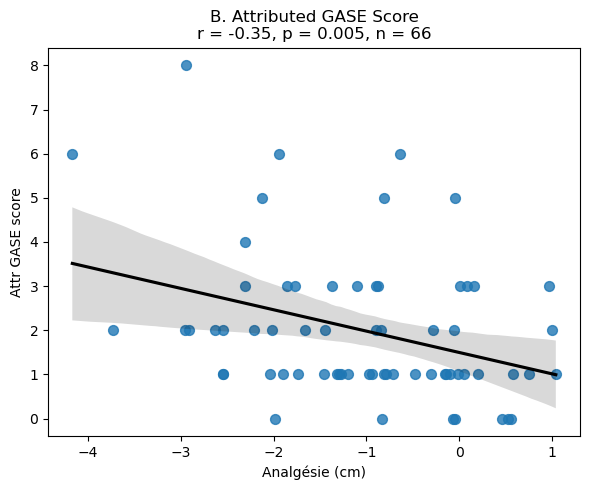

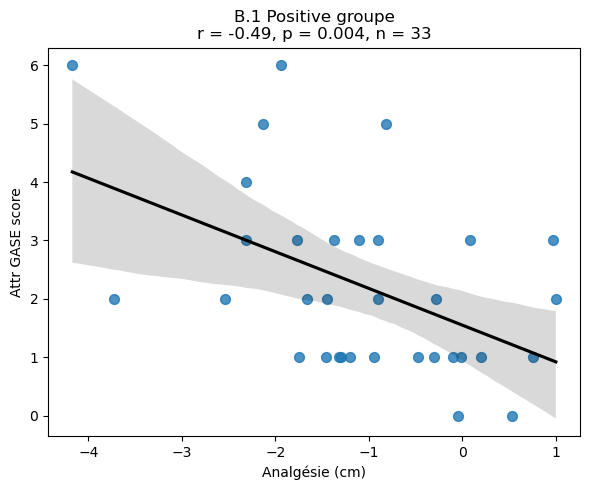

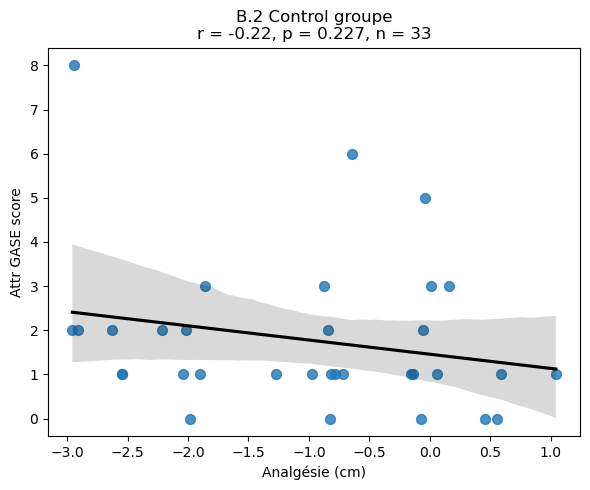

In [8]:

# ✅ Affichage des 6 graphes analytiques (effets secondaires vs analgésie)

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Création des groupes (au cas où pas encore faits)
df['Delta_Mean_Mod'] = df['mean_mod_Après'] - df['mean_mod_Av']

gase_cols = [col for col in df.columns if col.startswith("gase")]
df['Total_GASE_score'] = df[gase_cols].sum(axis=1)
df['Attr_GASE_score'] = df[gase_cols].apply(lambda row: (row == 1).sum(), axis=1)

df['Groupe'] = df['@1N_2P'].replace({1: 'Contrôle', 2: 'Positif'})
groupe_all = df
groupe_positif = df[df['Groupe'] == 'Positif']
groupe_controle = df[df['Groupe'] == 'Contrôle']

graphes = [
    ("A. Total GASE Score", 'Total_GASE_score', groupe_all),
    ("A.1 Positive groupe", 'Total_GASE_score', groupe_positif),
    ("A.2 Control groupe", 'Total_GASE_score', groupe_controle),
    ("B. Attributed GASE Score", 'Attr_GASE_score', groupe_all),
    ("B.1 Positive groupe", 'Attr_GASE_score', groupe_positif),
    ("B.2 Control groupe", 'Attr_GASE_score', groupe_controle)
]

for titre, ycol, sous_df in graphes:
    valid_df = sous_df[['Delta_Mean_Mod', ycol]].dropna()

    plt.figure(figsize=(6, 5))
    if len(valid_df) >= 2:
        sns.regplot(
            data=valid_df,
            x='Delta_Mean_Mod',
            y=ycol,
            scatter_kws={'s': 50, 'alpha': 0.8},
            line_kws={'color': 'black'}
        )
        r, p = pearsonr(valid_df['Delta_Mean_Mod'], valid_df[ycol])
        plt.title(f"{titre}\nr = {r:.2f}, p = {p:.3f}, n = {len(valid_df)}")
    else:
        plt.text(0.5, 0.5, "Pas assez de données", ha='center', va='center')
        plt.title(f"{titre} (données insuffisantes)")

    plt.xlabel("Analgésie (cm)")
    plt.ylabel(ycol.replace("_", " "))
    plt.tight_layout()
    plt.show()


#### les resultats obtenus dans l'article 

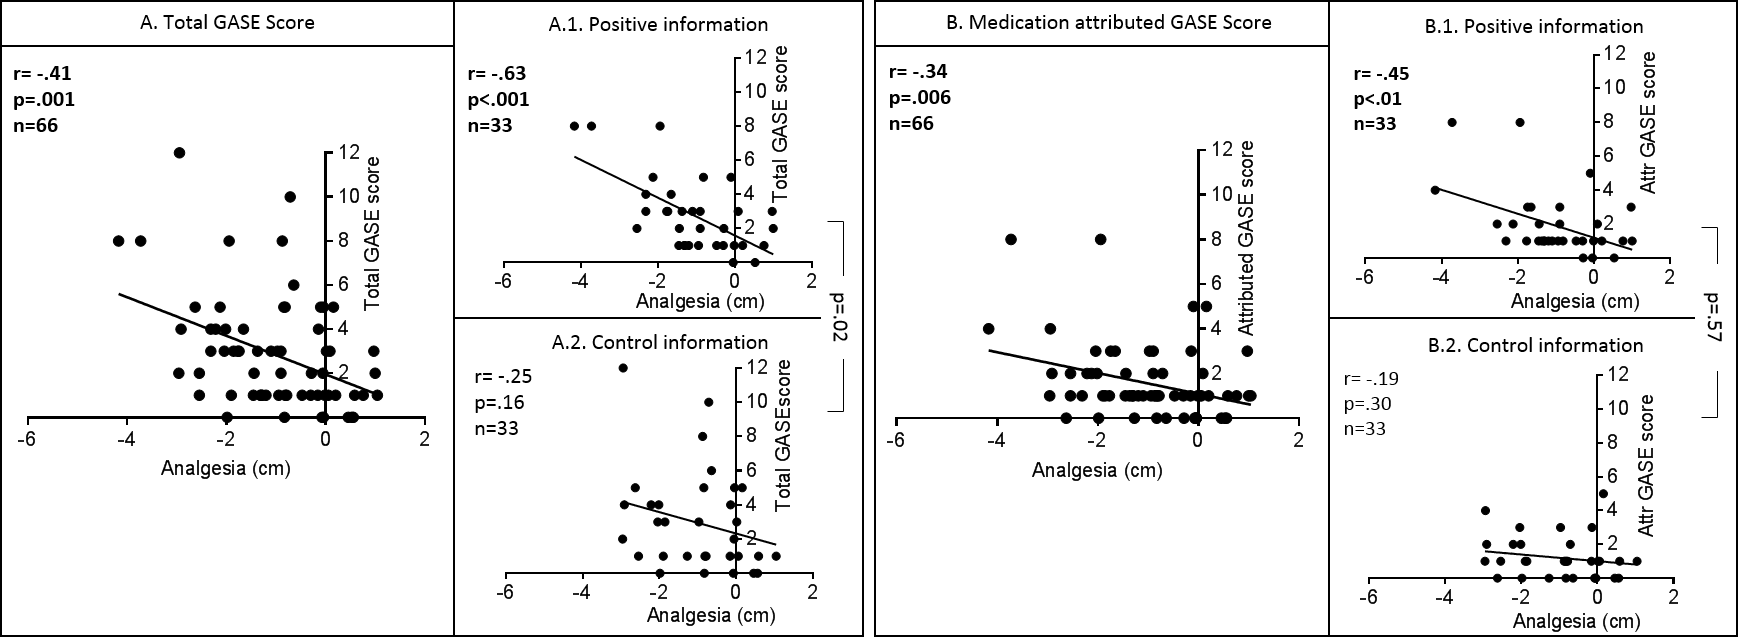



**A — Total GASE Score**

r = **-0.41**, p = **0.001**, n = **66**.  
La corrélation est modérée, négative et statistiquement significative. Cela indique que plus la douleur diminue, moins les participants perçoivent d'effets secondaires. Ce résultat est cohérent avec les observations de l'article.

---

**A.1 — Total GASE Score (groupe positif)**

r = **-0.62**, p = **0.000**, n = **33**.  
La corrélation est forte, négative et hautement significative. Dans le groupe ayant reçu un cadrage positif, une forte analgésie est clairement associée à une réduction des effets secondaires perçus. Ce résultat est en accord avec l'article, qui montre un renforcement de cette relation sous cadrage positif.

---

**A.2 — Total GASE Score (groupe contrôle)**

r = **-0.25**, p = **0.157**, n = **33**.  
La corrélation est faible à modérée et non significative. Sans cadrage positif, la diminution de la douleur n'est pas fortement liée à la perception des effets secondaires. Ce résultat est conforme aux données de l'article.

---

**B — Attributed GASE Score**

r = **-0.35**, p = **0.005**, n = **66**.  
La corrélation est modérée, négative et significative. Elle montre que plus la douleur diminue, moins les effets secondaires sont attribués au médicament. Ce résultat est en adéquation avec les observations rapportées dans l'article.

---

**B.1 — Attributed GASE Score (groupe positif)**

r = **-0.49**, p = **0.004**, n = **33**.  
La corrélation est modérée à forte, négative et significative. Sous cadrage positif, une forte analgésie est liée à une attribution réduite des effets secondaires au médicament. Ce résultat est cohérent avec les effets attendus du cadrage positif selon l'article.

---

**B.2 — Attributed GASE Score (groupe contrôle)**

r = **-0.22**, p = **0.227**, n = **33**.  
La corrélation est faible et non significative. Dans le groupe contrôle, l'analgésie n'est pas fortement reliée à l'attribution des effets secondaires au médicament, ce qui est en ligne avec les résultats de l'article.

---

**Commentaire général**

Globalement, les résultats montrent que le cadrage positif amplifie la relation entre la réduction de la douleur et la perception d'effets secondaires. Dans le groupe contrôle, ces corrélations restent faibles et non significatives, ce qui confirme les hypothèses et les conclusions de l'étude initiale.


## 3.🎯 Test de permutation sur la variable Delta_Mean_Mod

L'objectif est de comparer les deux groupes (**Contrôle** et **Positif**) pour la variable `Delta_Mean_Mod`, qui mesure l'évolution de la douleur.  
On veut savoir si la différence observée entre les deux groupes est due au hasard ou non.

Pour cela, on utilise un **test de permutation** :
- On mélange les participants entre les deux groupes,
- On recalcule la différence de moyenne à chaque fois,
- Et on regarde où se situe la vraie différence observée par rapport à cette distribution.

Si la vraie différence est très rare (loin dans la distribution), alors elle est probablement significative.

Le graphique ci-dessous montre la distribution des différences obtenues par permutation,  
et la ligne rouge correspond à la différence réellement observée dans les données.


📌 p-value du test de permutation (manuel) : 0.9327


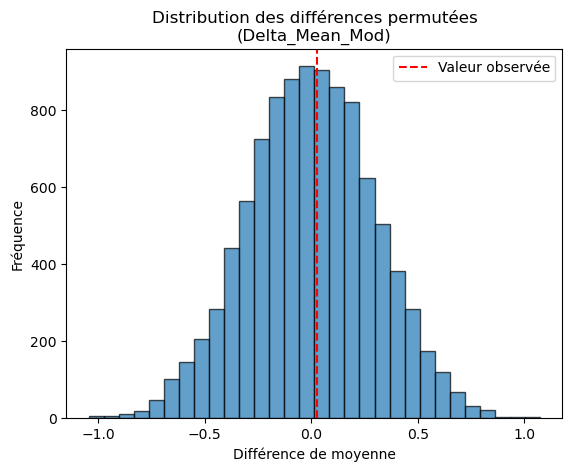

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Données
g0 = df[df['Groupe'] == 'Contrôle']['Delta_Mean_Mod'].dropna().values
g1 = df[df['Groupe'] == 'Positif']['Delta_Mean_Mod'].dropna().values

# Statistique observée
stat_obs = np.mean(g0) - np.mean(g1)

# Combiner les deux groupes
combined = np.concatenate([g0, g1])
n_g0 = len(g0)

# Liste pour stocker les statistiques permutées
n_permutations = 10000
stats = []

np.random.seed(42)  # reproductibilité

for _ in range(n_permutations):
    np.random.shuffle(combined)
    perm_g0 = combined[:n_g0]
    perm_g1 = combined[n_g0:]
    stats.append(np.mean(perm_g0) - np.mean(perm_g1))

# Calcul de la p-valeur bilatérale
stats = np.array(stats)
p_value = np.mean(np.abs(stats) >= np.abs(stat_obs))

# Affichage de la p-valeur
print("📌 p-value du test de permutation (manuel) :", p_value)

# Visualisation
plt.hist(stats, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(stat_obs, color='red', linestyle='--', label='Valeur observée')
plt.title("Distribution des différences permutées\n(Delta_Mean_Mod)")
plt.xlabel("Différence de moyenne")
plt.ylabel("Fréquence")
plt.legend()
plt.show()


## 📈 Bootstrap (tirage avec remise) sur Delta_Mean_Mod

Contrairement au test de permutation qui mélange les groupes sans remise,  
le bootstrap consiste à tirer **avec remise** des échantillons pour estimer l'incertitude  
sur une statistique, ici la **différence de moyenne** entre les deux groupes.

On répète ce tirage 10 000 fois pour créer une distribution de la statistique,  
puis on peut calculer un **intervalle de confiance à 95%** et le comparer à la valeur observée.


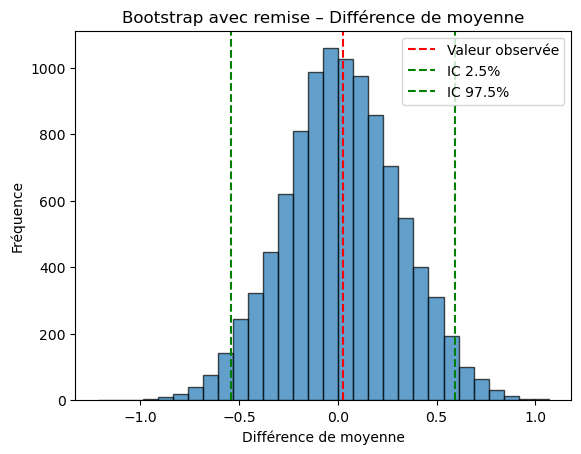

Intervalle de confiance à 95% : [-0.542, 0.594]


In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Données réelles
g0 = df[df['Groupe'] == 'Contrôle']['Delta_Mean_Mod'].dropna().values
g1 = df[df['Groupe'] == 'Positif']['Delta_Mean_Mod'].dropna().values

# Statistique observée
stat_obs = np.mean(g0) - np.mean(g1)

# Bootstrap avec remise
n_bootstrap = 10000
stats_boot = []

np.random.seed(42)
for _ in range(n_bootstrap):
    sample_g0 = np.random.choice(g0, size=len(g0), replace=True)  # ⬅️ avec remise
    sample_g1 = np.random.choice(g1, size=len(g1), replace=True)
    stats_boot.append(np.mean(sample_g0) - np.mean(sample_g1))

# Intervalle de confiance (exemple à 95 %)
ci_lower = np.percentile(stats_boot, 2.5)
ci_upper = np.percentile(stats_boot, 97.5)

# Affichage
plt.hist(stats_boot, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(stat_obs, color='red', linestyle='--', label='Valeur observée')
plt.axvline(ci_lower, color='green', linestyle='--', label='IC 2.5%')
plt.axvline(ci_upper, color='green', linestyle='--', label='IC 97.5%')
plt.title("Bootstrap avec remise – Différence de moyenne")
plt.xlabel("Différence de moyenne")
plt.ylabel("Fréquence")
plt.legend()
plt.show()

print(f"Intervalle de confiance à 95% : [{ci_lower:.3f}, {ci_upper:.3f}]")


### 📊 Interprétation du bootstrap

Le graphique ci-dessus montre la distribution des différences de moyenne entre les groupes Contrôle et Positif, obtenues par bootstrap (tirage avec remise).

- La **valeur observée** (en rouge) est proche de **0**, ce qui indique une faible différence entre les groupes.
- L’**intervalle de confiance à 95 %** (lignes vertes) contient la valeur 0.

➡️ Cela signifie qu’on **ne peut pas rejeter l’hypothèse nulle** :  
la différence observée **peut être due au hasard**.

Autrement dit, les groupes **ne sont probablement pas significativement différents** pour cette variable (`Delta_Mean_Mod`).
